# Out-of-Distributin detection on different OoD and with different metrics

In [1]:
import tensorflow.compat.v1 as tf
# #To make tf 2.0 compatible with tf1.0 code, we disable the tf2.0 functionalities
#tf.disable_eager_execution()
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
import sys
import pickle
from functools import partial


plt.rcParams.update({'font.family' : 'lmodern', 'font.size': 16,                                                                                                                                                    
                     'axes.labelsize': 16, 'legend.fontsize': 12, 
                     'xtick.labelsize': 16, 'ytick.labelsize': 16, 'axes.titlesize': 16,
                     'axes.linewidth': 1.5}) 

In [2]:
import scipy

In [3]:
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors

In [4]:
from pae.model_tf2 import get_prior

In [5]:
import pae.create_datasets as crd
import pae.load_data as ld
load_funcs=dict(mnist=ld.load_mnist, fmnist=ld.load_fmnist)

In [6]:
import os
import pickle
PROJECT_PATH = '/global/u2/v/vboehm/codes/PAE/'
PARAMS_PATH = os.path.join(PROJECT_PATH,'params')

param_file = 'params_fmnist_-1_40_infoGAN_VAE_best_params_noaugment_full_sigmaVAE_beta0'
params      = pickle.load(open(os.path.join(PARAMS_PATH,param_file+'.pkl'),'rb'))


In [7]:
params['data_dir']

'/global/cscratch1/sd/vboehm/Datasets'

In [8]:
load_func                                          = partial(load_funcs[params['data_set']])
x_train, y_train, x_valid, y_valid, x_test, y_test = load_func(params['data_dir'],flatten=False)

if np.all(x_test)==None:
    x_test=x_valid

x_train    = x_train/255.-0.5
x_test     = x_test/255.-0.5
x_valid    = x_valid/255.-0.5

In [9]:
def get_outliers(dataset,flip='no'):
    if dataset=='omniglot':
        import tensorflow_datasets as tfds
        from skimage.transform import resize
        omni= tfds.load('omniglot')
        glot = tfds.as_numpy(omni)
        samples=[]
        for sample in glot['test']:
            s = resize(sample['image'],(28,28))
            samples.append(-(s-0.5))
        samples=np.asarray(samples)
        samples = np.mean(samples[0:10000],axis=-1)
        x_valid_ood=np.expand_dims(samples,-1)
        x_test_ood=x_valid_ood
    else:
        load_func                                         = partial(load_funcs[dataset])
        x_train_ood, y_train, x_valid_ood, y_valid, x_test_ood, y_test = load_func(params['data_dir'],flatten=False)

        if np.any(x_test_ood)is None:
            x_test_ood=x_valid_ood

        if  flip=='horizontal':
            x_test_ood    = np.asarray([np.fliplr(x) for x in x_test_ood/255.-0.5])
        elif flip=='vertical':
            x_test_ood    = np.asarray([np.flipud(x) for x in x_test_ood/255.-0.5])
        else:
            x_test_ood    = x_test_ood/255.-0.5

    for ii in range(2):
        plt.imshow(np.squeeze(x_test_ood[ii]),cmap='gray')
        plt.axis('off')
        plt.show()
    return x_test_ood

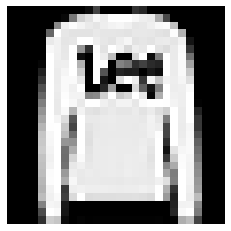

In [140]:
plt.imshow(np.squeeze(x_test[1]),cmap='gray')
plt.axis('off')
plt.show()

### To reproduce results choose either 'mnist', 'fmnist', or 'omniglot'. To flip use keyword 'horizontal' or 'vertical'

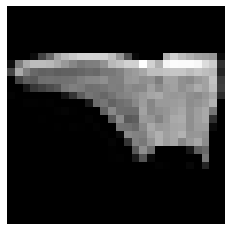

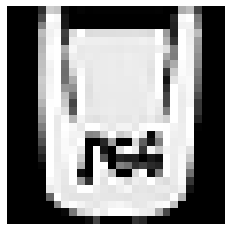

In [111]:
ood_set='fmnist'
flip='vertical'
x_valid_ood=get_outliers(ood_set, flip=flip)

In [112]:
generator_path   = os.path.join(params['module_dir'],'decoder')
encoder_path     = os.path.join(params['module_dir'],'encoder')
nvp_path         = os.path.join(params['module_dir'],'tag7_130')

In [113]:
def get_likelihood(decoder,sigma):
  
    def likelihood(z):
        mean = decoder({'z':z})['x']
        return tfd.Independent(tfd.MultivariateNormalDiag(loc=mean,scale_diag=sigma))

    return likelihood

def get_posterior(encoder):

    def posterior(x):
        mu, sigma        = tf.split(encoder({'x':x})['z'], 2, axis=-1)
        sigma            = tf.nn.softplus(sigma) + 1e-6
        approx_posterior = tfd.MultivariateNormalLinearOperator(loc=mu,scale=tf.linalg.LinearOperatorDiag(sigma))

        #approx_posterior = tfd.MultivariateNormalDiag(loc=mu, scale_diag=sigma)
        return approx_posterior

    return posterior

In [114]:
sigma         = params['full_sigma']
sigma         = tf.cast(sigma,tf.float32)
print(sigma.shape)
encoder       = hub.KerasLayer(encoder_path,trainable=False, signature_outputs_as_dict=True)
decoder       = hub.KerasLayer(generator_path, trainable=False, signature_outputs_as_dict=True)
nvp_funcs     = hub.KerasLayer(nvp_path, trainable=False, signature_outputs_as_dict=True)

(28, 28, 1)


In [115]:
likelihood       = get_likelihood(decoder,sigma)
prior            = get_prior(params['latent_size'])

In [116]:
def bwd_pass(z):
    return nvp_funcs({'z_sample':z,'sample_size':1, 'u_sample':np.zeros((1,params['latent_size']))})['bwd_pass']

def fwd_pass(u):
    return nvp_funcs({'z_sample':np.zeros((1,params['latent_size'])),'sample_size':1, 'u_sample':u})['fwd_pass']


def compute_nvp_prior(z):
    return nvp_funcs({'z_sample':z,'sample_size':1, 'u_sample':np.zeros((1,params['latent_size']))})['log_prob']

def inverse_log_det_jacobian(z):
    MAP_Gauss        = prior.log_prob(bwd_pass(z))
    MAP_prior        = nvp_funcs({'z_sample':z,'sample_size':1, 'u_sample':np.zeros((1,params['latent_size']))})['log_prob']
    # the Jacobian should be the difference
    NF_Jac           = MAP_prior - MAP_Gauss
    return NF_Jac

def get_encoded(x):
    mu, sig = tf.split(encoder({'x':x})['z'],2, axis=-1)
    return mu

def get_decoded(z):
    return decoder({'z':z})['x']

def prior_eval(z,nvp_funcs=nvp_funcs):
    prior         = nvp_funcs({'z_sample':z,'sample_size':1, 'u_sample':np.zeros((1,params['latent_size']))})['log_prob']
    return prior

In [117]:
def get_pz(data):
    mu = get_encoded(data)
    return prior_eval(mu)
    

In [118]:
def get_pxz(data):
    MAP = get_encoded(data)
    return likelihood(MAP).log_prob(data)

def get_recon_error(data):
    z = get_encoded(data)
    decoded = get_decoded(z)
    recon = -tf.reduce_mean(tf.square(decoded-data),axis=(1,2))
    return recon

def get_joint(data):
    return get_pz(data)+get_pxz(data)

In [119]:
# def get_ELBO(data):
#     bijector1=tfb.Inline(forward_fn=fwd_pass,inverse_fn=bwd_pass,inverse_log_det_jacobian_fn=inverse_log_det_jacobian, forward_min_event_ndims=params['latent_size'])
#     new_prior = tfd.TransformedDistribution(distribution=tfd.Normal(loc=0., scale=1.),bijector=bijector1)
    
#     posterior         = get_posterior(encoder)
#     approx_posterior  = posterior(data)
#     bijector2=tfb.Inline(forward_fn=lambda x: x,inverse_fn=lambda x: x,inverse_log_det_jacobian_fn=lambda x: 1, forward_min_event_ndims=params['latent_size'])
#     other  = tfd.TransformedDistribution(distribution=approx_posterior,bijector=bijector2)

#     kl                = tfd.kl_divergence(new_prior,other)
#     posterior_sample  = approx_posterior.sample()
#     sample_likelihood = likelihood(posterior_sample).log_prob(data)
#     ELBO              = sample_likelihood-kl
#     return ELBO

In [120]:
# get_ELBO(x_valid_ood[0:256])

Full Measured Sigma, log_post with single sample, Log Likelihood at Encoded and Reconstruction

prior

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



nats: 20.008747
bits per dim: 0.03681954109281758
AUROC: 0.89


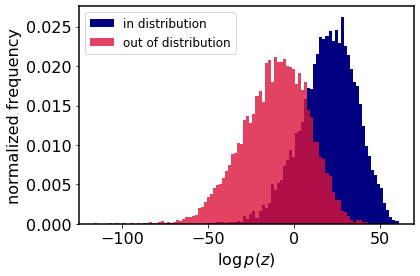

likelihood
nats: 1007.6072
bits per dim: 1.8541707633692692
AUROC: 0.886


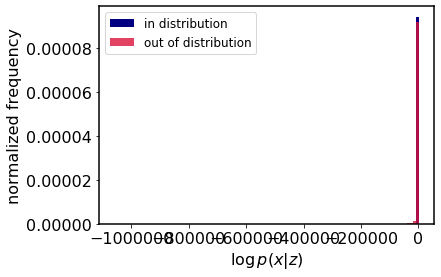

recon_error
nats: -0.006032148
bits per dim: -1.1100191168761562e-05
AUROC: 0.873


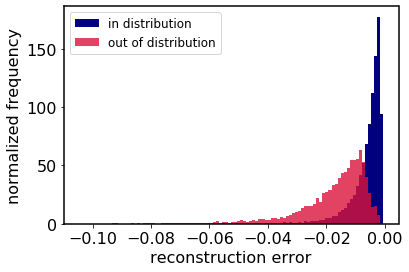

Laplace_without_Volume
nats: 1027.5356
bits per dim: 1.8908425748748459
AUROC: 0.889


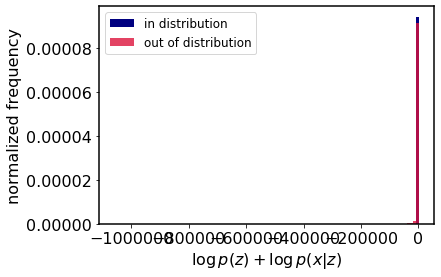

In [121]:
from scipy.integrate import simps

metrics = ['prior','likelihood', 'recon_error', 'Laplace_without_Volume']
labels  = [r'$\mathrm{log}\, p(z)$',r'$\mathrm{log}\, p(x|z)$', 'reconstruction error',r'$\mathrm{log}\, p(z)+\mathrm{log}\, p(x|z)$' ]
objs    = [get_pz, get_pxz, get_recon_error, get_joint]


AUROC=[]
false_positive=[]
encoded_oods=[]
sig = np.maximum(params['full_sigma'],10)
for jj in range(len(metrics)):
    print(metrics[jj])
    objective=[]
    for ii in range(len(x_valid)//params['batch_size']):
        data_sample = x_valid[ii*params['batch_size']:(ii+1)*params['batch_size']]
        objective+=[objs[jj](data_sample)]
    delta = len(x_valid)%params['batch_size']
    data_sample = np.concatenate((x_valid[(ii+1)*params['batch_size']:len(x_valid)],x_valid[0:params['batch_size']-delta]))
    objective+=[objs[jj](data_sample)]
    objective = np.asarray(objective).flatten()[0:len(x_valid)]

    objective_ood=[]
    for ii in range(len(x_valid_ood)//params['batch_size']):
        data_sample = x_valid_ood[ii*params['batch_size']:(ii+1)*params['batch_size']]
        encoded_oods+=[get_encoded(data_sample)]
        objective_ood+=[objs[jj](data_sample)]
    delta = len(x_valid)%params['batch_size']
    data_sample = np.concatenate((x_valid_ood[(ii+1)*params['batch_size']:len(x_valid_ood)],x_valid_ood[0:params['batch_size']-delta]))
    encoded_oods+=[get_encoded(data_sample)]
    objective_ood+=[objs[jj](data_sample)]
    objective_ood = np.asarray(objective_ood).flatten()[0:len(x_valid)]
    encoded_OOD =  np.asarray(encoded_oods).reshape((-1,params['latent_size']))[0:len(x_valid)]
    np.save(os.path.join(params['data_dir'],ood_set+flip+'_VAE40_encoded.npy'),encoded_OOD)

    objective = np.asarray(objective)
    objective_ood = np.asarray(objective_ood)
    objs_ = np.sort(objective)
    objs_ood_ = np.sort(objective_ood)
    print('nats:', np.mean(objs_))
    print('bits per dim:', np.mean(objs_)/np.log(2)/(28*28))
    false_pos=[]
    true_pos=[]
    for ii in range(10000):
        val = objs_[ii]
        true_pos.append(len(np.where(objs_>=val)[0])/len(objs_))
        false_pos.append(len(np.where(objs_ood_>=val)[0])/len(objs_))
    false_pos = np.asarray(false_pos,dtype=np.float64)
    AUROC+=[1-np.sum(false_pos)*1./np.float(len(objs_))]
    print('AUROC:',np.round(AUROC[-1],3))
    mini = min(min(np.sort(objective)[2:]),min(np.sort(objective_ood)[2:]))
    maxi = max(max(objective),max(objective_ood))
    plt.figure()
    _ = plt.hist(objective, bins=100, color='navy',density=True, range=(mini,maxi), label='in distribution')
    _ = plt.hist(objective_ood, bins=100, color='crimson', alpha=0.8, density=True, range=(mini,maxi), label='out of distribution')
    plt.xlabel(labels[jj])
    plt.ylabel('normalized frequency')
    plt.legend()
    plt.savefig(os.path.join(params['plot_dir'],ood_set+flip+'_'+metrics[jj]+'.pdf'),bbox_inches='tight')
    plt.show()
false_positive.append(false_pos)

In [123]:
path = '/global/cscratch1/sd/vboehm/RNF/modules/fmnist/class-1/latent_size40/net_type_infoGAN/loss_VAE/best_params_full_sigmaVAE_beta0/GIS/'

In [124]:
def compute_AUROC(objs_,objs_ood_):
    false_pos=[]
    true_pos=[]
    for ii in range(10000):
        val = objs_[ii]
        true_pos.append(len(np.where(objs_>=val)[0])/len(objs_))
        false_pos.append(len(np.where(objs_ood_>=val)[0])/len(objs_))
    false_pos = np.asarray(false_pos,dtype=np.float64)
    AUROC=1-np.sum(false_pos)*1./np.float(len(objs_))
    print('AUROC:',np.round(AUROC,3))
    return AUROC



In [125]:
ood_set = 'test0'
logps = np.load(os.path.join(path,'logp_%s.npy'%ood_set))


mnist
AUROC: 0.998


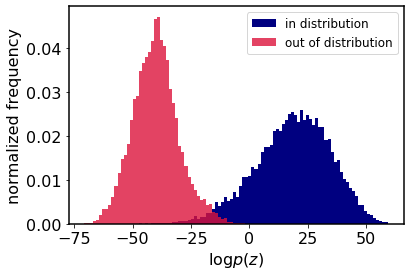

omniglot
AUROC: 0.981


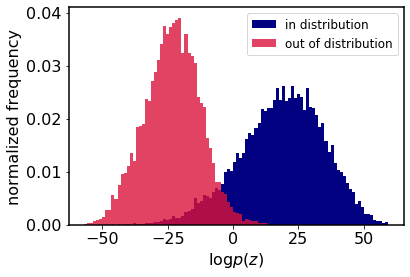

mnistvertical
AUROC: 0.998


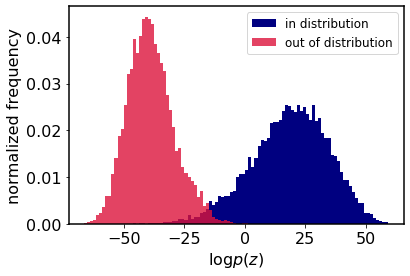

mnisthorizontal
AUROC: 0.998


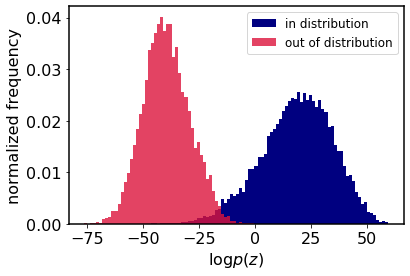

fmnistvertical
AUROC: 0.876


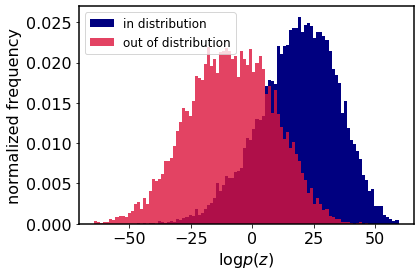

fmnisthorizontal
AUROC: 0.689


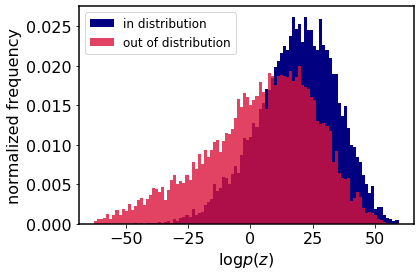

In [126]:

for ood_set in ['mnist','omniglot', 'mnistvertical', 'mnisthorizontal', 'fmnistvertical', 'fmnisthorizontal']:
    print(ood_set)

    logps_ood = np.load(os.path.join(path,'logp_%s.npy'%ood_set))
    compute_AUROC(logps,logps_ood)
    mini = min(min(np.sort(logps)[2:]),min(np.sort(logps_ood)[2:]))
    maxi = max(max(logps),max(logps_ood))
    plt.figure()
    _ = plt.hist(logps, bins=100, color='navy',density=True, range=(mini,maxi), label='in distribution')
    _ = plt.hist(logps_ood, bins=100, color='crimson', alpha=0.8, density=True, range=(mini,maxi), label='out of distribution')
    plt.xlabel(r'$\mathrm{log} p(z)$')
    plt.ylabel('normalized frequency')
    plt.legend()
    plt.savefig(os.path.join(params['plot_dir'],ood_set+'_'+'GIS_logp'+'.pdf'),bbox_inches='tight')
    plt.show()

In [164]:
kde = pickle.load(open('kde_VAE_fit.pkl', 'rb'))
data_dir = '/global/cscratch1/sd/vboehm/Datasets'

In [174]:
for ood_set in ['mnist','omniglot', 'mnistvertical', 'mnisthorizontal', 'fmnistvertical', 'fmnisthorizontal']:
    data = np.load(os.path.join(data_dir,ood_set+'_VAE40_encoded.npy'))
    logps= kde.score_samples(data)
    np.save(os.path.join(data_dir,'logp_VAE_%s.npy'%ood_set),logps)


In [175]:
encodeds= []
for ii in range(10000//256):
    encodeds.append(get_encoded(x_valid[ii*256:(ii+1)*256]))


In [176]:
delta = len(x_valid)%params['batch_size']
data_sample = np.concatenate((x_valid[(ii+1)*params['batch_size']:len(x_valid)],x_valid[0:params['batch_size']-delta]))

In [177]:
encodeds.append(get_encoded(data_sample))

In [178]:
encodeds=np.asarray(encodeds).reshape(-1,params['latent_size'])[0:10000]

In [179]:
logps= kde.score_samples(encodeds)
np.save(os.path.join(data_dir,'logp_VAE_%s.npy'%'fmnist'), logps)

In [180]:
logps

array([ 23.01993927, -12.42899542,  23.95865259, ...,  11.93572253,
        27.55983706,  20.30492002])

mnist
AUROC: 0.917


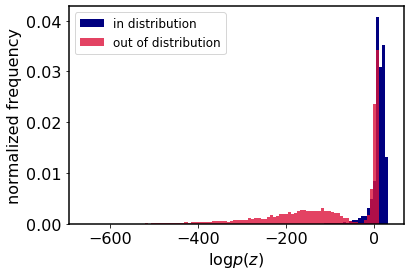

omniglot
AUROC: 0.877


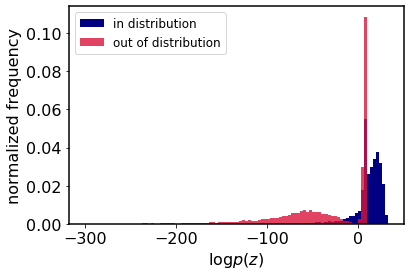

mnistvertical
AUROC: 0.912


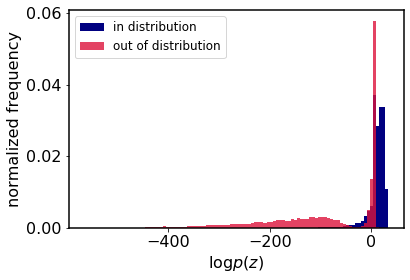

mnisthorizontal
AUROC: 0.915


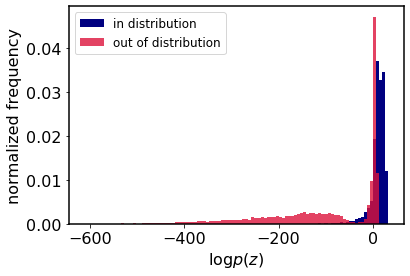

fmnistvertical
AUROC: 0.818


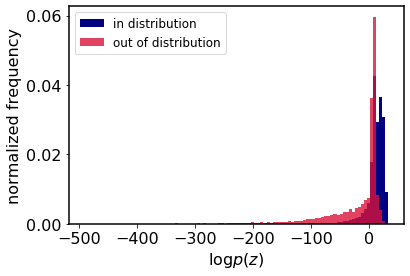

fmnisthorizontal
AUROC: 0.664


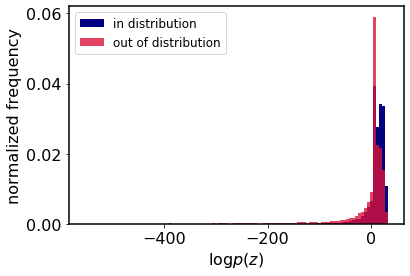

In [181]:
for ood_set in ['mnist','omniglot', 'mnistvertical', 'mnisthorizontal', 'fmnistvertical', 'fmnisthorizontal']:
    print(ood_set)

    logps_ood = np.load(os.path.join(data_dir,'logp_VAE_%s.npy'%ood_set))
    compute_AUROC(logps,logps_ood)
    mini = min(min(np.sort(logps)[2:]),min(np.sort(logps_ood)[2:]))
    maxi = max(max(logps),max(logps_ood))
    plt.figure()
    _ = plt.hist(logps, bins=100, color='navy',density=True, range=(mini,maxi), label='in distribution')
    _ = plt.hist(logps_ood, bins=100, color='crimson', alpha=0.8, density=True, range=(mini,maxi), label='out of distribution')
    plt.xlabel(r'$\mathrm{log} p(z)$')
    plt.ylabel('normalized frequency')
    plt.legend()
    plt.savefig(os.path.join(params['plot_dir'],ood_set+'_'+'KDE_logp'+'.pdf'),bbox_inches='tight')
    plt.show()